# ノートブックの概要
SAR model によるモンテカルロシミュレーションと、EBCMによる情報拡散ダイナミクスの記述を比較する。

## 使用方法
1. Jupyter Notebook または Google Colab で開く
2. 各セルを順番に実行する
3. 必要に応じてデータを変更して再実行


In [1]:
# 必要なライブラリをインポート
import numpy as np
import matplotlib.pyplot as plt
import sys
from math import comb
from matplotlib.gridspec import GridSpec
from scipy.stats import poisson
import seaborn as sns
import os
import ast
import csv

# プロジェクトのsrcディレクトリをimportパスに追加
module_path = os.path.abspath(os.path.join('..', '..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from utils import *
from ebcm import *

# グラフ全体のフォント設定
plt.rcParams['font.family'] = 'serif'  # 全体のフォントをSerifに設定
plt.rcParams['mathtext.fontset'] = 'cm'  # 数式のフォントをComputer Modernに設定
plt.rcParams['mathtext.rm'] = 'serif'  # TeXの通常フォントをSerifに設定
plt.rcParams['font.size'] = 18  # デフォルトフォントサイズ
plt.rcParams['axes.labelsize'] = 18  # 軸ラベルのフォントサイズ
plt.rcParams['axes.titlesize'] = 22  # タイトルのフォントサイズ
plt.rcParams['legend.fontsize'] = 16  # 凡例のフォントサイズ
plt.rcParams['grid.color'] = 'gray'  # グリッドの色を薄い灰色に設定
plt.rcParams['grid.linestyle'] = ':'  # グリッドを点線に設定
plt.rcParams['grid.linewidth'] = 0.5  # グリッドの線幅を設定

In [2]:
"""
Simulation result loader utilities
----------------------------------
parameters.csv / args.csv の読み込みと
複数バッチのシミュレーション結果 CSV を結合する。

Usage::
    $ python load_results.py
"""

from __future__ import annotations

import ast
import csv
import os
from pathlib import Path
from typing import Any, Dict, Tuple

import numpy as np


# --------------------------------------------------------------------------- #
# CSV ローダー
# --------------------------------------------------------------------------- #
def load_simulation_parameters(file_path: str | Path) -> Dict[str, Any]:
    """
    parameters.csv を読み込み、パラメータ辞書を返す。

    CSV フォーマット::
        Parameter,Type,Value
        Network,String,ER
        V,Integer,10000
        ...

    Returns
    -------
    dict
        パラメータ名をキー、値をバリューとする辞書
    """
    params: Dict[str, Any] = {}
    with Path(file_path).open(encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            key = row["Parameter"]
            value_str = row["Value"]
            try:
                params[key] = ast.literal_eval(value_str)
            except Exception:  # fallback: keep as string
                params[key] = value_str
    return params


def load_simulation_args(
    file_path: str | Path,
) -> Tuple[np.ndarray, np.ndarray, int, int]:
    """
    args.csv からシミュレーション引数を読み込む。

    Returns
    -------
    alpha_values : np.ndarray
    lambda_values : np.ndarray
    iterations    : int
    max_time      : int
    """
    with Path(file_path).open(encoding="utf-8") as f:
        reader = csv.reader(f)
        _header = next(reader)      # skip header row
        row = next(reader)
        alpha_str, lambda_str, iterations_str, max_time_str = row

    alpha_values = np.array(ast.literal_eval(alpha_str), dtype=float)
    lambda_values = np.array(ast.literal_eval(lambda_str), dtype=float)
    iterations = int(iterations_str)
    max_time = int(max_time_str)
    return alpha_values, lambda_values, iterations, max_time


def load_simulation_result(
    file_pattern: str,
    num_alpha: int,
    num_lambda: int,
    batch: int,
    iterations: int,
    max_time: int,
    results_dir: str | Path = ".",
) -> np.ndarray:
    """
    1 バッチ分の結果 CSV を 4 次元配列に整形して返す。

    Notes
    -----
    ``file_pattern="s_all_results.csv"`` でバッチ 2 の場合、
    ファイル名は ``s_all_results_2.csv`` となる。
    """
    filename = file_pattern.replace(".csv", f"_{batch}.csv")
    file_path = Path(results_dir) / filename

    if not file_path.exists():
        raise FileNotFoundError(file_path)

    data = np.loadtxt(file_path, delimiter=",", skiprows=1, dtype=int)
    try:
        return data.reshape(num_alpha, num_lambda, iterations, max_time + 1)
    except ValueError as err:
        raise ValueError(
            f"{file_path} を "
            f"({num_alpha}, {num_lambda}, {iterations}, {max_time + 1}) "
            f"に reshape できません: {err}"
        ) from err


def load_all_batches(
    file_pattern: str,
    num_alpha: int,
    num_lambda: int,
    iterations: int,
    num_batches: int,
    max_time: int,
    results_dir: str | Path = ".",
) -> np.ndarray:
    """
    全バッチを連結して (num_alpha, num_lambda, num_batches*iterations, max_time+1)
    の ndarray を返す。
    """
    total_iters = num_batches * iterations
    concat = np.empty(
        (num_alpha, num_lambda, total_iters, max_time + 1), dtype=int
    )

    idx = 0
    for batch in range(1, num_batches + 1):
        batch_data = load_simulation_result(
            file_pattern,
            num_alpha,
            num_lambda,
            batch,
            iterations,
            max_time,
            results_dir,
        )
        concat[:, :, idx : idx + iterations, :] = batch_data
        idx += iterations

    return concat


# --------------------------------------------------------------------------- #
# エントリポイント
# --------------------------------------------------------------------------- #
if __name__ == "__main__":
    # 結果ディレクトリ (Java 側と合わせる)
    RESULTS_DIR = Path("..") / ".." / "simulation_results"

    # ------------------ パラメータ読み込み ------------------ #
    params_path = RESULTS_DIR / "parameters.csv"
    params = load_simulation_parameters(params_path)

    network: str = params["Network"]
    N: int = int(params["numVertices"])
    k_ave: int = int(params["averageDegree"])
    iterations: int = int(params["iterations"])
    max_time: int = int(params["maxTime"])
    num_batches: int = int(params["numBatches"])
    gamma: float = float(params["gamma"])
    p: float = float(params["p"])
    t_pair = (1, 4)  # 活動家、偏屈家それぞれの閾値

    rho0 = 1.0 / N
    p_list = [p, 1.0 - p]

    # ------------------ 引数読み込み ------------------ #
    args_path = RESULTS_DIR / "args.csv"
    alpha_values, lambda_values, iterations, max_time = load_simulation_args(
        args_path
    )

    print("Simulation Params")
    print("=================")
    print(f"Network          : {network}")
    print(f"N                : {N:,}")
    print(f"Average degree   : {k_ave}")
    print(f"Gamma            : {gamma}")
    print(f"p                : {p}")
    print(f"Iterations/batch : {iterations}")
    print(f"Batches          : {num_batches}")
    print(f"Max time         : {max_time}")
    print()

    # ------------------ 結果読み込み ------------------ #
    num_alpha = len(alpha_values)
    num_lambda = len(lambda_values)

    aa_results = load_all_batches(
        "aa_all_results.csv",
        num_alpha,
        num_lambda,
        iterations,
        num_batches,
        max_time,
        RESULTS_DIR,
    )
    ab_results = load_all_batches(
        "ab_all_results.csv",
        num_alpha,
        num_lambda,
        iterations,
        num_batches,
        max_time,
        RESULTS_DIR,
    )
    r_results = load_all_batches(
        "r_all_results.csv",
        num_alpha,
        num_lambda,
        iterations,
        num_batches,
        max_time,
        RESULTS_DIR,
    )

    print("Loaded arrays")
    print("-------------")
    print(f"aa_results shape: {aa_results.shape}")
    print(f"ab_results shape: {ab_results.shape}")
    print(f" r_results shape: {r_results.shape}")


Simulation Params
Network          : ER
N                : 10,000
Average degree   : 10
Gamma            : 1.0
p                : 0.2
Iterations/batch : 100
Batches          : 1
Max time         : 100

Loaded arrays
-------------
aa_results shape: (110, 100, 100, 101)
ab_results shape: (110, 100, 100, 101)
 r_results shape: (110, 100, 100, 101)


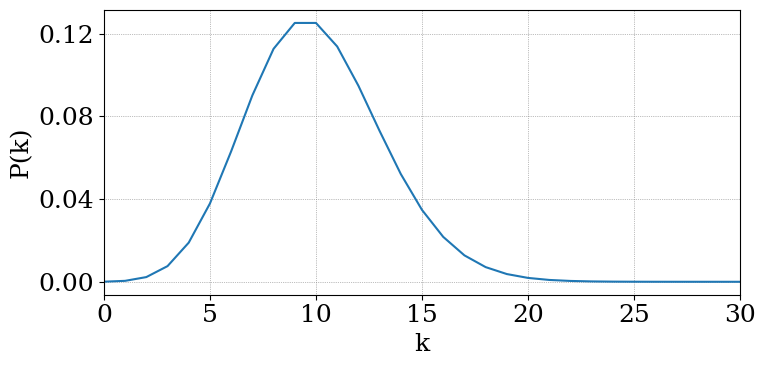

In [3]:
# 平均次数k_aveのER(エルデシュ・レーニ)グラフの次数分布p(k)
pk_poi = poisson.pmf(np.arange(N), k_ave)
lowest_degree_for_ana=1
highest_degree_for_ana=N-1
k_vals_for_ana = np.arange(1, 3*k_ave)

# p(k)の描画
degree = np.arange(N)
plt.figure(figsize=(8,4))
plt.plot(degree, pk_poi)

# グラフの設定
plt.xlabel('k')
plt.ylabel('P(k)')
plt.xlim(0,3*k_ave)
plt.grid(True, linestyle=':')
plt.yticks(np.arange(0, 0.14, 0.04))
plt.tight_layout()

# グラフを表示
plt.show()

In [ ]:
# 離散の時間ステップ
dt = 1
time_steps = (max_time + 1) / dt
times_con = np.arange(0, time_steps * dt, dt)

# 2次元配列の準備
# パラメータθ
theta_t_ana = np.zeros(((len(alpha_values), len(lambda_values), len(times_con))))
# パラメータq
q_t_ana = np.zeros(((len(alpha_values), len(lambda_values), len(times_con))))
# 活動家でSusceptibleの割合
sl_t_ana = np.zeros(((len(alpha_values), len(lambda_values), len(times_con))))
# 偏屈家でSusceptibleの割合
sh_t_ana = np.zeros(((len(alpha_values), len(lambda_values), len(times_con))))
# 活動家でInfectedの割合
aa_t_ana = np.zeros(((len(alpha_values), len(lambda_values), len(times_con))))
# 偏屈家でInfectedの割合
ab_t_ana = np.zeros(((len(alpha_values), len(lambda_values), len(times_con))))
# 活動家でRecoveredの割合
ra_t_ana = np.zeros(((len(alpha_values), len(lambda_values), len(times_con))))
# 偏屈家でRecoveredの割合
rb_t_ana = np.zeros(((len(alpha_values), len(lambda_values), len(times_con))))

# ルンゲクッタ法で解を求める
for alpha_idx, alpha in enumerate(alpha_values):
    if alpha_idx % 25 == 0:
        print(f"alpha: {alpha:.2f}")
    for lamb_idx, lamb in enumerate(lambda_values):
        if (alpha_idx % 25 == 0) and (lamb_idx % 50 == 0):
            print(f" --> lambda: {lamb:.2f}")

        y0 = [1, 1, 1 - rho0, 1 - rho0, rho0, rho0, 0, 0]
        result = runge_kutta4(sar_derivatives, y0, times_con, lamb, gamma, rho0, p, alpha, k_vals_for_ana, pk_poi, k_ave, t_pair)
        theta, q, sl, sh, aa, ab, ra, rb = result.T

        # 結果を保存
        theta_t_ana[alpha_idx, lamb_idx, :] = theta
        q_t_ana[alpha_idx, lamb_idx, :] = q
        sl_t_ana[alpha_idx, lamb_idx, :] = sl
        sh_t_ana[alpha_idx, lamb_idx, :] = sh
        aa_t_ana[alpha_idx, lamb_idx, :] = aa
        ab_t_ana[alpha_idx, lamb_idx, :] = ab
        ra_t_ana[alpha_idx, lamb_idx, :] = ra
        rb_t_ana[alpha_idx, lamb_idx, :] = rb

r_t_ana = p * ra_t_ana + (1 - p) * rb_t_ana

alpha: 0.00
 --> lambda: 0.00
 --> lambda: 0.50
alpha: 0.25
 --> lambda: 0.00
 --> lambda: 0.50
alpha: 0.50
 --> lambda: 0.00
 --> lambda: 0.50


In [27]:
# 全てのイテレーションの平均
aa_results_ave = np.mean(aa_results, axis=2) / p_list[0]/N
ab_results_ave = np.mean(ab_results, axis=2) / p_list[1]/N
r_results_ave = np.mean(r_results, axis=2) / N

# 全てのイテレーションの標準偏差
aa_results_std = np.std(aa_results, axis=2) / p_list[0]/N
ab_results_std = np.std(ab_results, axis=2) / p_list[1]/N
r_results_std = np.std(r_results, axis=2) / N

In [28]:
# 有効イテレーションのうちの平均と標準偏差を格納する配列の初期化
shape = (len(alpha_values), len(lambda_values), max_time+1)
aa_results_ave_valid = np.zeros(shape)
ab_results_ave_valid = np.zeros(shape)
a_results_ave_valid = np.zeros(shape)
r_results_ave_valid = np.zeros(shape)

aa_results_std_valid = np.zeros(shape)
ab_results_std_valid = np.zeros(shape)
a_results_std_valid = np.zeros(shape)
r_results_std_valid = np.zeros(shape)

# 各 alpha と lambda の組み合わせについて計算
for alpha_idx, alpha in enumerate(alpha_values):
    for lamb_idx, lamb in enumerate(lambda_values):
        valid = []
        # 有効なイテレーションを抽出
        for iteration in range(iterations):
            if r_results[alpha_idx, lamb_idx, iteration, -1] > 20:
                valid.append(iteration)
        
        if valid:
            # 有効なデータを抽出
            aa_valid = aa_results[alpha_idx, lamb_idx, valid, :]
            ab_valid = ab_results[alpha_idx, lamb_idx, valid, :]
            r_valid = r_results[alpha_idx, lamb_idx, valid, :]
            
            # 平均と標準偏差を計算し、Vとp_listで割る
            aa_results_ave_valid[alpha_idx, lamb_idx, :] = np.mean(aa_valid, axis=0) / N / p_list[0]
            ab_results_ave_valid[alpha_idx, lamb_idx, :] = np.mean(ab_valid, axis=0) / N / p_list[1]
            r_results_ave_valid[alpha_idx, lamb_idx, :] = np.mean(r_valid, axis=0) / N
            
            aa_results_std_valid[alpha_idx, lamb_idx, :] = np.std(aa_valid, axis=0) / N / p_list[0]
            ab_results_std_valid[alpha_idx, lamb_idx, :] = np.std(ab_valid, axis=0) / N / p_list[1]
            r_results_std_valid[alpha_idx, lamb_idx, :] = np.std(r_valid, axis=0) / N
        else:
            # 有効なイテレーションがない場合、全イテレーションを対象に計算
            aa_valid = aa_results[alpha_idx, lamb_idx, :, :]
            ab_valid = ab_results[alpha_idx, lamb_idx, :, :]
            r_valid = r_results[alpha_idx, lamb_idx, :, :]
            
            # 平均と標準偏差を計算し、Vとp_listで割る
            aa_results_ave_valid[alpha_idx, lamb_idx, :] = np.mean(aa_valid, axis=0) / N / p_list[0]
            ab_results_ave_valid[alpha_idx, lamb_idx, :] = np.mean(ab_valid, axis=0) / N / p_list[1]
            r_results_ave_valid[alpha_idx, lamb_idx, :] = np.mean(r_valid, axis=0) / N
            
            aa_results_std_valid[alpha_idx, lamb_idx, :] = np.std(aa_valid, axis=0) / N / p_list[0]
            ab_results_std_valid[alpha_idx, lamb_idx, :] = np.std(ab_valid, axis=0) / N / p_list[1]
            r_results_std_valid[alpha_idx, lamb_idx, :] = np.std(r_valid, axis=0) / N

# 結果の確認
print("平均の形状:", aa_results_ave_valid.shape)
print("標準偏差の形状:", aa_results_std_valid.shape)

平均の形状: (110, 100, 101)
標準偏差の形状: (110, 100, 101)


In [29]:
# 時間発展を図示目するα,λのインデックス
alpha_idx_list = [0, 40]
lamb_idx_list = [70, 90]

network: ER
N: 10000
(Ta, Tb): (1, 4)
iterations: 100
p: 0.2
rho0: 0.0001
gamma: 1.0


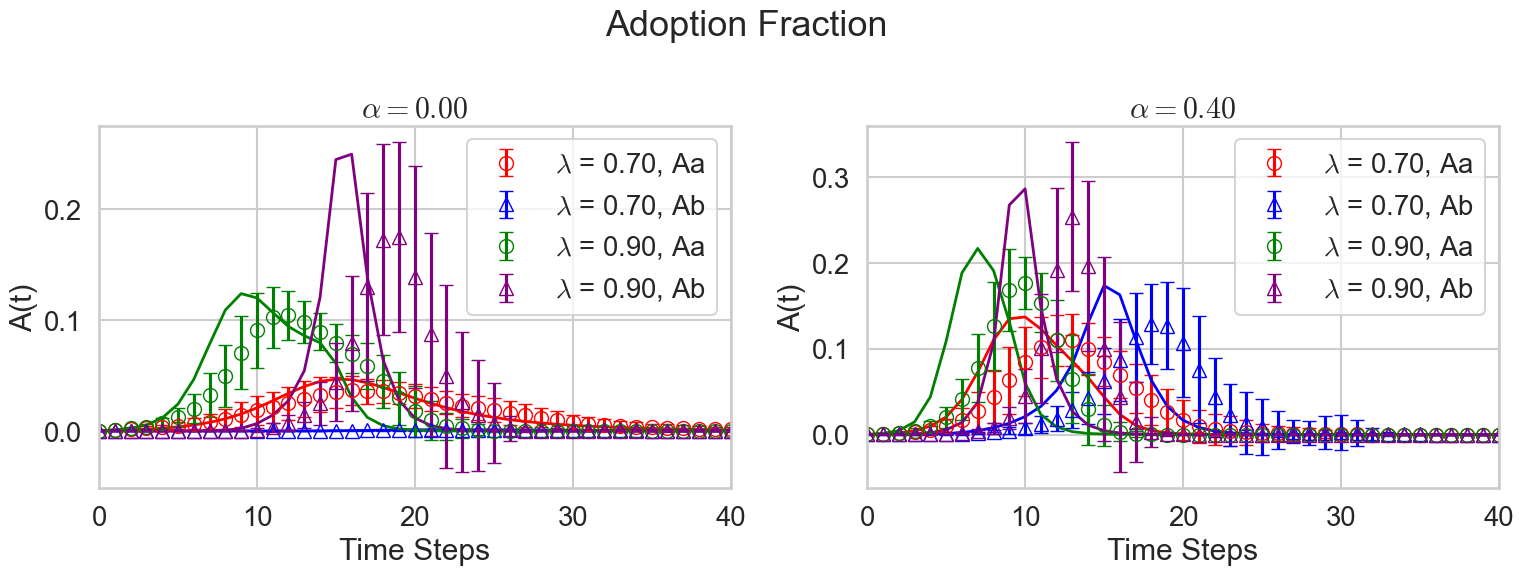

In [46]:
overall_times = np.arange(0, max_time + 1, 1)

print("network:", network)
print("N:", N)
print("(Ta, Tb):", tuple(t_pair))
print("iterations:", iterations)
print("p:", p)
print("rho0:", rho0)
print("gamma:", gamma)

plt.figure(figsize=(16, 6))
colors = ['red', 'blue', 'green', 'purple']

for a, alpha_idx in enumerate(alpha_idx_list):
    alpha = alpha_values[alpha_idx]
    plt.subplot(1, len(alpha_idx_list), a + 1)
    color_idx = 0
    for lamb_idx in lamb_idx_list:
        lamb = lambda_values[lamb_idx]
        # Aa の結果
        plt.errorbar(overall_times,
                    aa_results_ave_valid[alpha_idx, lamb_idx],
                    yerr=aa_results_std_valid[alpha_idx, lamb_idx],
                    capsize=5,
                    fmt='o',
                    markerfacecolor='none',
                    markeredgecolor=colors[color_idx], 
                    ecolor=colors[color_idx],
                    markersize=10,
                    label=rf'$\lambda$ = {lamb:.2f}, Aa')
        
        # Aa のEBCMによる近似
        plt.plot(times_con,
                    aa_t_ana[alpha_idx][lamb_idx],
                    linestyle='-',
                    linewidth=2,
                    color=colors[color_idx])

        # Ab の結果
        plt.errorbar(overall_times,
                    ab_results_ave_valid[alpha_idx, lamb_idx],
                    yerr=ab_results_std_valid[alpha_idx, lamb_idx],
                    capsize=5,
                    fmt='^',
                    markerfacecolor='none',
                    markeredgecolor=colors[color_idx + 1], 
                    ecolor=colors[color_idx + 1],
                    markersize=10,
                    label=rf'$\lambda$ = {lamb:.2f}, Ab')

        # Ab のEBCMによる近似
        plt.plot(times_con,
                    ab_t_ana[alpha_idx][lamb_idx],
                    linestyle='-',
                    linewidth=2,
                    color=colors[color_idx + 1])

        color_idx += 2
    plt.xlabel('Time Steps')
    plt.ylabel('A(t)')
    plt.xlim(0, 40)
    plt.title(rf'$\alpha={alpha:.2f}$')
    plt.legend(loc='best')  # ラベルを表示
    plt.grid(True)  # グリッドを表示

plt.tight_layout()  # suptitle を考慮
plt.show()

### 実践とプロットのズレ

* 初期採用者が極端に少ない場合、採用者が増え始めるタイミングに揺らぎが出てしまう。
* 採用者が最大値になったタイミングを統一することで、その後のダイナミクスを精度高く近似できる。

In [35]:
aa_max_indices = np.argmax(aa_t_ana, axis=2)
ab_max_indices = np.argmax(ab_t_ana, axis=2)

a_t_ana = p_list[0] * aa_t_ana + p_list[1] * ab_t_ana
r_t_ana = p_list[0] * ra_t_ana + p_list[1] * rb_t_ana

a_max_indices = np.argmax(a_t_ana, axis=2)
r_max_indices = np.argmax(r_t_ana, axis=2)

In [36]:
# 平均と標準偏差を格納する配列の初期化
shape = (len(alpha_values), len(lambda_values), iterations, max_time+1)
aa_results_align = np.zeros(shape)
ab_results_align = np.zeros(shape)
a_results_align = np.zeros(shape)
r_results_align = np.zeros(shape)

# 各時系列データをアラインメント
for alpha_idx in range(len(alpha_values)):
    for lamb_idx in range(len(lambda_values)):
        for i in range(iterations):
            # aa_resultsのアラインメント
            aa_results_align[alpha_idx, lamb_idx, i, :] = align_to_max(
                aa_results[alpha_idx, lamb_idx, i, :],
                ref_index=aa_max_indices[alpha_idx, lamb_idx]
            )
            
            # ab_resultsのアラインメント
            ab_results_align[alpha_idx, lamb_idx, i, :] = align_to_max(
                ab_results[alpha_idx, lamb_idx, i, :],
                ref_index=ab_max_indices[alpha_idx, lamb_idx,]
            )
            
            # r_resultsのアラインメント
            r_results_align[alpha_idx, lamb_idx, i, :] = align_to_max(
                r_results[alpha_idx, lamb_idx, i, :],
                ref_index=r_max_indices[alpha_idx, lamb_idx]
            )



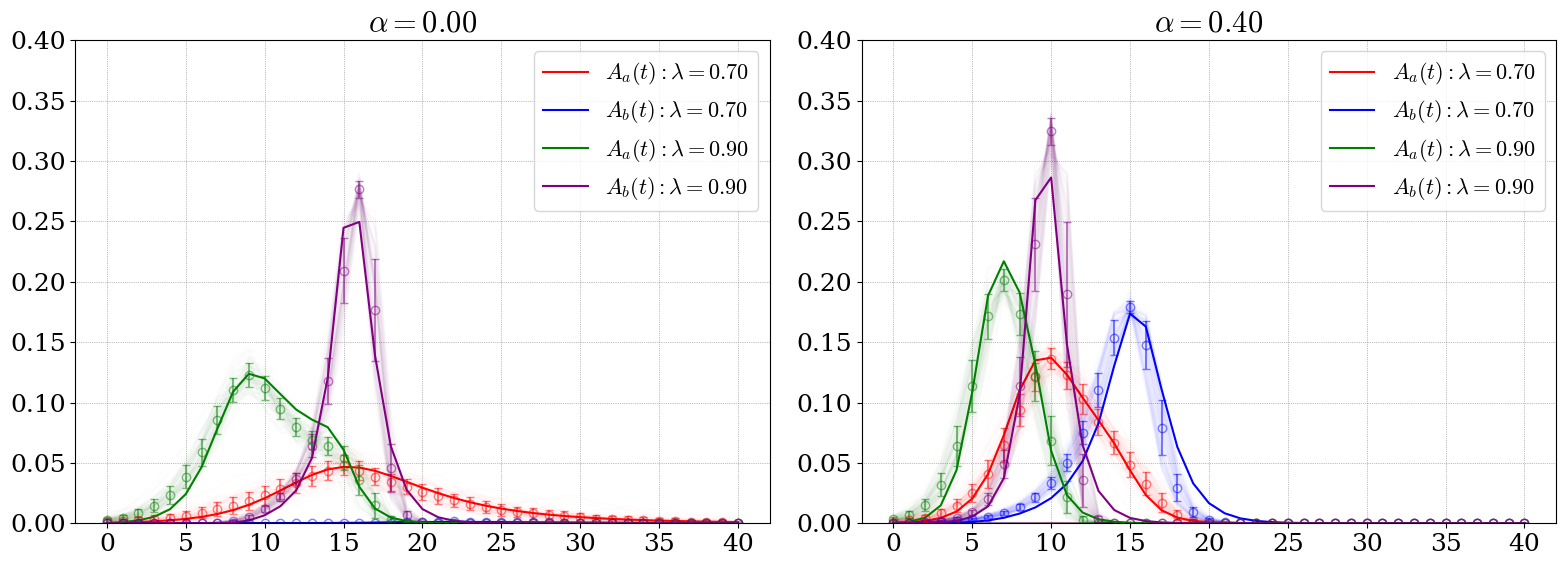

In [42]:
plt.figure(figsize=(16,6))
# plt.suptitle(f'All simulation over time: {network}', fontsize=18)
markers = ['o', 's', '^']  # マーカーの種類
last_time = 40

for a, alpha_idx in enumerate(alpha_idx_list):
    alpha = alpha_values[alpha_idx]
    plt.subplot(1, len(alpha_idx_list), a+1)
    plt.title(rf'$\alpha={alpha:.2f}$')

    for l, lamb_idx in enumerate(lamb_idx_list):
        lamb = lambda_values[lamb_idx]
        valid_trials = [] # 条件を満たす試行のインデックスを保存

        for iteration in range(iterations):
            if iteration == 1:
                plt.plot([],[],linestyle='-',color=colors[2*l],alpha=1,label=rf'$A_a(t): \lambda={lamb:.2f}$')
                plt.plot([],[],linestyle='-',color=colors[2*l+1],alpha=1,label=rf'$A_b(t): \lambda={lamb:.2f}$')

            plt.plot(np.arange(last_time + 1),
                    aa_results_align[alpha_idx, lamb_idx, iteration, :last_time+1] / (p_list[0]*N),
                    linestyle='-',
                    color=colors[2*l],
                    alpha=0.01)
            plt.plot(np.arange(last_time + 1),
                    ab_results_align[alpha_idx, lamb_idx, iteration, :last_time+1] / (p_list[1]*N),
                    linestyle='-',
                    color=colors[2*l+1],
                    alpha=0.01)

            # 条件を満たすかチェック
            if r_results_align[alpha_idx, lamb_idx, iteration, -1] > 20:
                valid_trials.append(iteration)

        # 有効な試行の平均と標準偏差を計算してプロット
        if valid_trials:
            # Aa(t) の平均と標準偏差
            mean_aa = np.mean(aa_results_align[alpha_idx, lamb_idx, valid_trials, :last_time+1], axis=0) / (p_list[0] * N)
            std_aa = np.std(aa_results_align[alpha_idx, lamb_idx, valid_trials, :last_time+1], axis=0) / (p_list[0] * N)
            
            # Ab(t) の平均と標準偏差
            mean_ab = np.mean(ab_results_align[alpha_idx, lamb_idx, valid_trials, :last_time+1], axis=0) / (p_list[1] * N)
            std_ab = np.std(ab_results_align[alpha_idx, lamb_idx, valid_trials, :last_time+1], axis=0) / (p_list[1] * N)
            
            # 標準偏差のエラーバーを追加
            plt.errorbar(np.arange(last_time + 1), mean_aa, yerr=std_aa, fmt=markers[0], markerfacecolor='none',color=colors[2*l], markersize=6,linestyle='',capsize=3,ecolor=colors[2*l], alpha=0.5)
            plt.errorbar(np.arange(last_time + 1), mean_ab, yerr=std_ab, fmt=markers[0], markerfacecolor='none',color=colors[2*l+1], markersize=6,linestyle='',capsize=3,ecolor=colors[2*l+1], alpha=0.5)
        else:
            # 有効な試行がない場合、全試行の平均と標準偏差をプロット
            mean_aa = np.mean(aa_results_align[alpha_idx, lamb_idx, :, :last_time+1], axis=0) / (p_list[0] * N)
            std_aa = np.std(aa_results_align[alpha_idx, lamb_idx, :, :last_time+1], axis=0) / (p_list[0] * N)
            
            mean_ab = np.mean(ab_results_align[alpha_idx, lamb_idx, :, :last_time+1], axis=0) / (p_list[1] * N)
            std_ab = np.std(ab_results_align[alpha_idx, lamb_idx, :, :last_time+1], axis=0) / (p_list[1] * N)
            
            # 標準偏差のエラーバーを追加
            plt.errorbar(np.arange(last_time + 1), mean_aa, yerr=std_aa, fmt=markers[0], markerfacecolor='none',color=colors[2*l], markersize=6,linestyle='',capsize=3,ecolor=colors[2*l], alpha=0.5)
            plt.errorbar(np.arange(last_time + 1), mean_ab, yerr=std_ab, fmt=markers[0], markerfacecolor='none',color=colors[2*l+1], markersize=6,linestyle='',capsize=3,ecolor=colors[2*l+1], alpha=0.5)

        plt.plot(np.arange(last_time + 1), aa_t_ana[alpha_idx, lamb_idx, :last_time+1], color=colors[2*l])
        plt.plot(np.arange(last_time + 1), ab_t_ana[alpha_idx, lamb_idx, :last_time+1], color=colors[2*l+1])

        plt.legend()
        plt.tight_layout()
    plt.ylim(0,0.4)
    plt.grid('True')
plt.show()


### 最終伝播規模

* 終状態における回復者の割合は、そのネットワーク上でどれだけ情報が拡散したかを評価する重要な指標となる。
* 口コミによる情報伝播の確率$\lambda$と、流行効果$\alpha$の二つのパラメータを動かした時の回復者割合を見る。

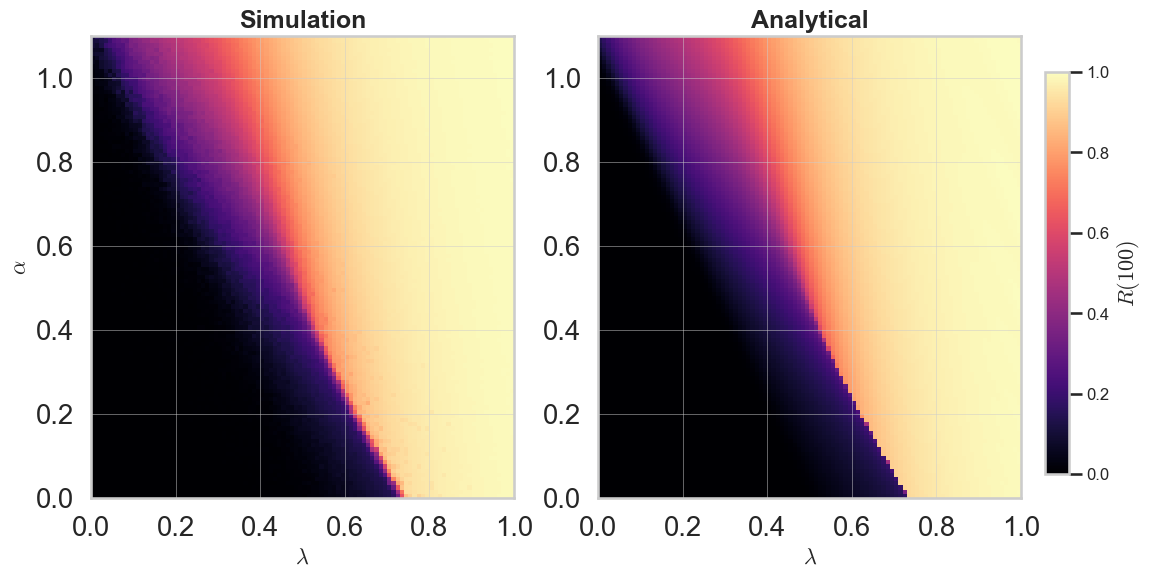

In [ ]:
# Seabornスタイルを使用
sns.set_context("talk", font_scale=1.2)
sns.set_style("whitegrid")

# 図の準備
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(1, 2, width_ratios=[1, 1], figure=fig)

# カラーマップの範囲を統一
vmin = 0
vmax = 1

# サブプロット1: シミュレーション結果
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(
    r_results_ave_valid[:,:,-1],
    extent=[0.0, 1.0, 0.0, 1.1],
    origin='lower',
    aspect='auto',
    cmap='magma',
    vmin=vmin,
    vmax=vmax
)
ax1.set_title("Simulation", fontsize=18, weight='bold')
ax1.set_xlabel(r"$\lambda$", fontsize=16)
ax1.set_ylabel(r"$\alpha$", fontsize=16, weight='bold')
ax1.grid(linewidth=0.5, alpha=0.7)  # グリッドを細く

# サブプロット2: 理論結果
ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(
    r_t_ana[:,:,-1],
    extent=[0.0, 1.0, 0.0, 1.1],
    origin='lower',
    aspect='auto',
    cmap='magma',
    vmin=vmin,
    vmax=vmax
)
ax2.set_title("Analytical", fontsize=18, weight='bold')
ax2.set_xlabel(r"$\lambda$", fontsize=16, weight='bold')
ax2.set_ylabel("")
ax2.grid(linewidth=0.5, alpha=0.7)  # グリッドを細く

# # カラーバーを全体で共有
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.67])  # 位置: [left, bottom, width, height]
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label(rf"$R({max_time})$", fontsize=16, weight='bold')
cbar.ax.tick_params(labelsize=12)

# レイアウト調整
plt.show()
